In [1]:
#Import dependencies and pop_cosmos
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle

from pop_cosmos.constants import COSMOS_FILTERS_LATEX
from pop_cosmos.catalogue import CatalogueGenerator
from pop_cosmos.utils import compute_derived_quantities, compute_mass_remaining

In [2]:
#Load model trained in Thorp et al. (2025) on the CPU
catalogue_generator = torch.load("../trained_models/catalogueModelCPU.pt", weights_only=False)

In [3]:
#Load a secondary emulator needed for some derived quantities
mass_remaining_emulator = torch.load("../trained_models/stellar_mass_emulator.pt", map_location="cpu", weights_only=False)
mass_theta_shift, mass_theta_scale = pickle.load(open("../trained_models/stellar_mass_parameter_shift-scale.pkl", "rb"))
mass_theta_shift = torch.from_numpy(mass_theta_shift)
mass_theta_scale = torch.from_numpy(mass_theta_scale)

In [4]:
#Generate base samples for the diffusion model
base_noise, base_sigma, base_phi = catalogue_generator.generate_base_samples(10000)

In [5]:
#Generate a representative catalogue from the model
noisy_fluxes, noisy_magnitudes, noisy_asinh_magnitudes, flux_sigmas, theta_samples, model_fluxes = catalogue_generator(base_noise, base_sigma, base_phi)

In [6]:
#Set the magnitude limit to 26 in IRAC Ch.1
lims = torch.inf*torch.ones(26)
lims[-2] = 26.0

#Generate a boolean tensor with information on which galaxies are selected
selection = catalogue_generator.selection_cut(noisy_fluxes, noisy_magnitudes, flux_sigmas, lims).detach().numpy()

#Compute some derived quantities that we might want
log10M_formed, mw_age, log10SFR, log10sSFR = compute_derived_quantities(theta_samples)
log10M_remain, log10sSFR, M_frac = compute_mass_remaining(log10M_formed, log10sSFR, theta_samples, mass_theta_shift, mass_theta_scale, mass_remaining_emulator)

#Move to numpy
noisy_magnitudes = noisy_magnitudes.detach().numpy()
noisy_fluxes = noisy_fluxes.detach().numpy()
flux_sigmas = flux_sigmas.detach().numpy()
theta_samples = theta_samples.detach().numpy()
log10M_samples = log10M_remain.detach().numpy()
log10SFR_samples = log10SFR.detach().numpy()

In [7]:
#Make the selection cut
noisy_magnitudes_selected = noisy_magnitudes[selection]
noisy_flux_sigmas_selected = flux_sigmas[selection]
thetas_selected = theta_samples[selection]
log10M_selected = log10M_samples[selection]
log10SFR_selected = log10SFR_samples[selection]

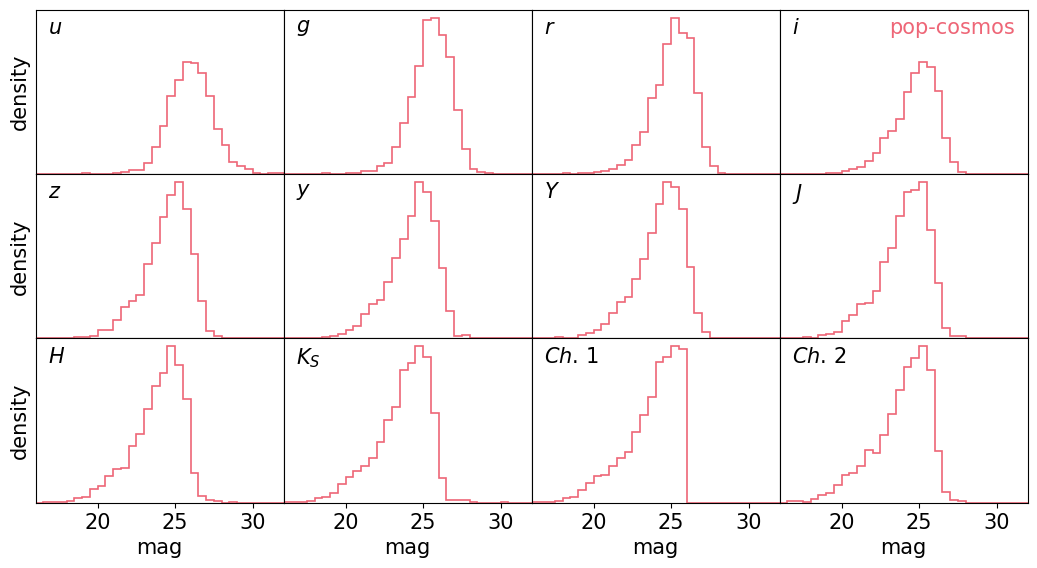

In [8]:
#Plot the broadband magnitudes(logarithmic) as predicted by the pop-cosmos model
plt.rcParams.update({"font.size": 15})
mag_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -2, -1]

x_bins = np.linspace(16, 32, 33)
hist_color = "#EE6677"
figsize = (12.8, 6.4)
xlim = (16, 32)
xticks = [20, 25, 30]

fig, axes = plt.subplots(3, 4, figsize=figsize)
axes = axes.flatten()

# Loop through all channels for a histogram plot
for i, mag_idx in enumerate(mag_list):
    ax = axes[i]
    
    ax.hist(noisy_magnitudes_selected[:, mag_idx], 
            color=hist_color, bins=x_bins, histtype="step", 
            linewidth=1.2, density=True)
    
    # Filter labels
    ax.text(0.05, 0.95, COSMOS_FILTERS_LATEX[mag_idx], 
            transform=ax.transAxes, verticalalignment='top')
    
    if i == 3:
        ax.text(0.95, 0.95, "pop-cosmos", transform=ax.transAxes, 
                verticalalignment='top', horizontalalignment="right", 
                color=hist_color)
    
    if i in [0, 3]: 
        ax.set_ylim(0, ax.get_ylim()[1] * 1.4)

    if i % 4 == 0: 
        ax.set_ylabel('density')
    ax.set_yticks([])
    
    ax.set_xlim(xlim)
    if i > 7: 
        ax.set_xlabel('mag')
        ax.set_xticks(xticks)
    else:
        ax.set_xticks([])

plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

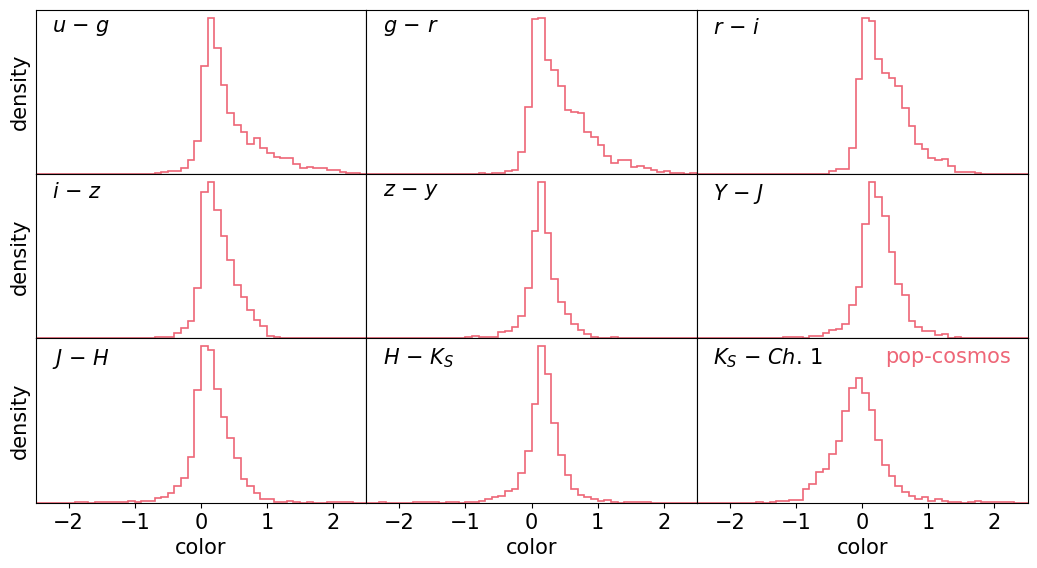

In [9]:
# Plot the broadband colors (logarithmic, adjacent bands) as predicted by the pop-cosmos model
mag_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -2]
x_bins = np.linspace(-2.5, 2.5, 51)
hist_color = "#EE6677"
figsize = (12.8, 6.4)
xlim = (-2.5, 2.5)
xticks = [-2, -1, 0, 1, 2]

# Create color pairs
color_pairs = [(mag_list[i], mag_list[i+1]) 
               for i in range(len(mag_list)-1) 
               if i != 5]


fig, axes = plt.subplots(3, 3, figsize=figsize)
axes = axes.flatten()

# Loop through all color pairs to create a histogram plot
for plot_idx, (mag1, mag2) in enumerate(color_pairs):
    ax = axes[plot_idx]
    
    # Calculate color difference
    color_diff = noisy_magnitudes_selected[:, mag1] - noisy_magnitudes_selected[:, mag2]
    

    ax.hist(color_diff, color=hist_color, bins=x_bins, 
            histtype="step", linewidth=1.2, density=True)
    

    color_label = f"{COSMOS_FILTERS_LATEX[mag1]} $-$ {COSMOS_FILTERS_LATEX[mag2]}"
    ax.text(0.05, 0.95, color_label, transform=ax.transAxes, 
            verticalalignment='top')
    
 
    if plot_idx == 8:
        ax.text(0.95, 0.95, "pop-cosmos", transform=ax.transAxes, 
                verticalalignment='top', horizontalalignment="right", 
                color=hist_color)
        ax.set_ylim(0, ax.get_ylim()[1] * 1.25)
    

    if plot_idx % 3 == 0:  
        ax.set_ylabel('density')
    ax.set_yticks([])
    

    ax.set_xlim(xlim)
    if plot_idx >= 6: 
        ax.set_xlabel('color')
        ax.set_xticks(xticks)
    else:
        ax.set_xticks([])


plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

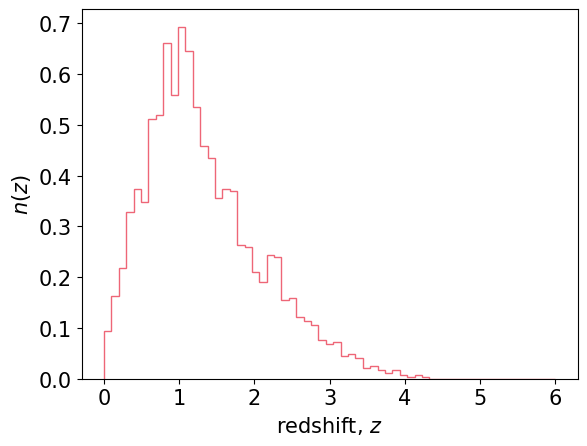

In [10]:
#Plot the reshift distribution predicted by the pop-cosmos model
plt.hist(thetas_selected[:,-1], bins=61, color="#EE6677", histtype="step", density=True, range=(0,6))
plt.xlabel("redshift, $z$")
plt.ylabel("$n(z)$")
plt.show()

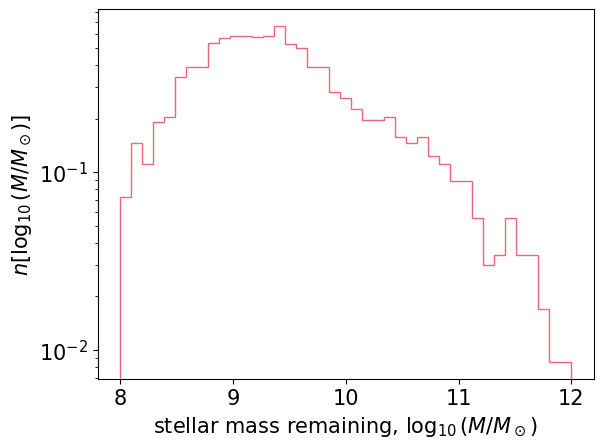

In [11]:
#Plot the stellar mass function predicted by the pop-cosmos model
plt.hist(log10M_selected, bins=41, color="#EE6677", histtype="step", density=True, range=(8,12))
plt.xlabel("stellar mass remaining, $\\log_{10}(M/M_\\odot)$")
plt.ylabel("$n[\\log_{10}(M/M_\\odot)]$")
plt.yscale("log")
plt.show()